In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('turkce_kelime_listesi.txt').read().splitlines()
words[:8]

['a', 'a', 'a / e', 'ab', 'aba', 'abacı', 'abacılık', 'abadi']

In [3]:
len(words)

76205

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: '\t', 2: ' ', 3: "'", 4: '-', 0: '.', 6: '/', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'F', 13: 'G', 14: 'H', 15: 'I', 16: 'J', 17: 'K', 18: 'L', 19: 'M', 20: 'N', 21: 'O', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'Y', 29: 'Z', 30: 'a', 31: 'b', 32: 'c', 33: 'd', 34: 'e', 35: 'f', 36: 'g', 37: 'h', 38: 'i', 39: 'j', 40: 'k', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'r', 47: 's', 48: 't', 49: 'u', 50: 'v', 51: 'y', 52: 'z', 53: 'Â', 54: 'Ç', 55: 'Ö', 56: 'Ü', 57: 'â', 58: 'ç', 59: 'î', 60: 'ö', 61: 'û', 62: 'ü', 63: 'ğ', 64: 'İ', 65: 'ı', 66: 'Ş', 67: 'ş'}


In [5]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([630511, 3]) torch.Size([630511])
torch.Size([78136, 3]) torch.Size([78136])
torch.Size([78522, 3]) torch.Size([78522])


In [7]:
X.shape, Y.shape

(torch.Size([787169, 3]), torch.Size([787169]))

In [44]:
C = torch.randn((68,10))

In [45]:
emb = C[X]
emb.shape

torch.Size([787169, 3, 10])

In [37]:
emb.view(32,6).shape

torch.Size([32, 6])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [14]:
h

tensor([[-0.6846, -0.5861, -0.4749,  ...,  0.5783, -0.7204,  0.0953],
        [-0.1790, -0.9102, -0.3852,  ...,  0.1278,  0.1733, -0.0208],
        [-0.6846, -0.5861, -0.4749,  ...,  0.5783, -0.7204,  0.0953],
        ...,
        [-0.9831,  0.9991, -0.8832,  ...,  0.9969, -0.9999, -0.9985],
        [ 0.9965, -1.0000,  0.6725,  ..., -0.9923,  0.9988, -0.9618],
        [ 0.9869,  0.8762,  0.3095,  ..., -1.0000,  0.9952,  0.9903]])

In [15]:
h.shape

torch.Size([787169, 100])

In [16]:
W2 = torch.randn((100, 68))
b2 = torch.randn(68)

In [17]:
logits = h @ W2 + b2
logits.shape

torch.Size([787169, 68])

In [18]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([787169, 68])

# ------- Rewrite of above code (clearer) -------

In [212]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [20]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((68,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 68), generator=g)
b2 = torch.randn(68, generator=g)
parameters = [C, W1, b1, W2, b2]

In [21]:
sum(p.nelement() for p in parameters) # number of parameters

20548

In [22]:
for p in parameters:
    p.requires_grad = True

In [23]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [24]:
lri = []
lossi = []
stepi = []

In [25]:
for i in range(200000):
    
    # minibatches
    ix = torch.randint(0, Xtr.shape[0], (68,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

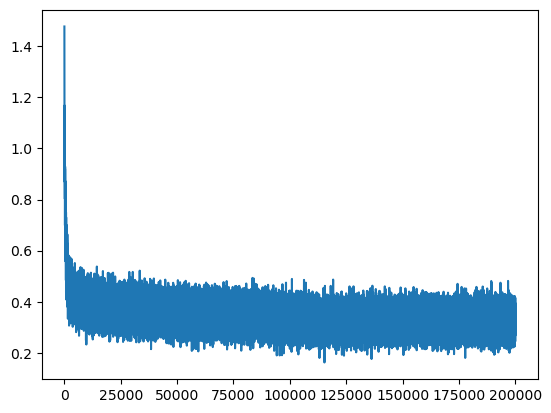

In [26]:
plt.plot(stepi, lossi)

In [27]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1253, grad_fn=<NllLossBackward0>)

In [28]:
emb = C[Xva] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.1498, grad_fn=<NllLossBackward0>)

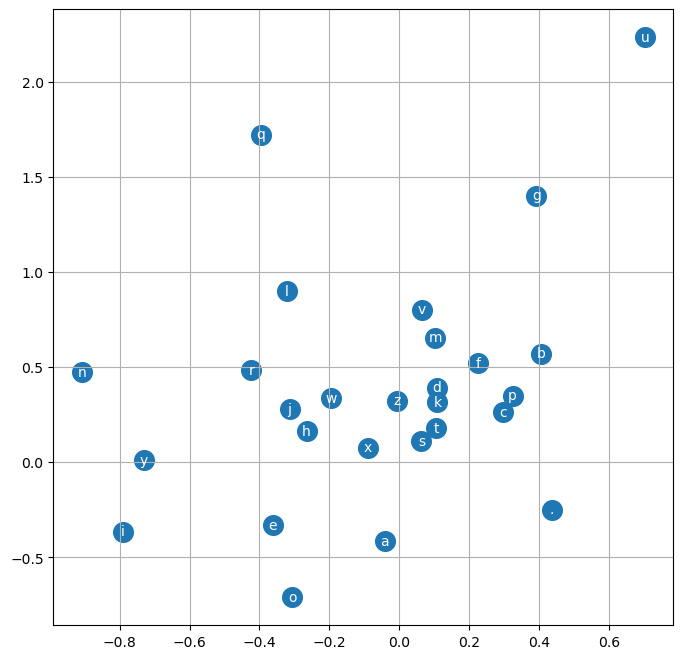

In [195]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color = 'white')
plt.grid('minor')

In [42]:
# sample from the model

g = torch.Generator().manual_seed(2147483616)

for _ in range(25):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

navrızlaj.
nağızlığı.
ter.
Karşaşi kaşış.
marlanığı köperli.
avden.
oyutçe.
orteklisebarısılık.
çarize.
pot.
çavusakcızı.
fatlık.
göfükleme.
dimünesnetlemek.
itfizm.
indirleşmek.
dilik.
bederağızlılı.
yanlı  hal.
yak dirmek.
boğatıkırda turbuter.
sandırma.
aklatmak.
kalı yakalı.
datlığırlaş.
